In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy.optimize import fsolve
import math

In [4]:
############################################
#
# Varying parameter (others fixed to default)
#
var_name = 'N_ur'
var_array = np.linspace(3.046,5.046,5)
var_num = len(var_array)
var_legend = r'$N_\mathrm{eff}$'
var_figname = 'neff'
#
# Constraints to be matched
#
# As explained in the "Neutrino cosmology" book, CUP, Lesgourgues et al., section 5.3, the goal is to vary
# - omega_cdm by a factor alpha = (1 + coeff*Neff)/(1 + coeff*3.046)
# - h by a factor sqrt*(alpha)
# in order to keep a fixed z_equality(R/M) and z_equality(M/Lambda)
#
# coefficient such that omega_r = omega_gamma (1 + coeff*Neff),
# i.e. such that omega_ur = omega_gamma * coeff * Neff:
# coeff = omega_ur/omega_gamma/Neff_standard
coeff = 1.710730e-05/2.472979e-05/3.046
print("coeff=",coeff)
#
#############################################
#
# Fixed settings
#
common_settings = {'output':'tCl,pCl,lCl,mPk',
                   'lensing':'yes',
                   # fixed LambdaCDM parameters
                   'omega_b':0.022032,
                   'A_s':2.215e-9,
                   'n_s':0.9619,
                   'tau_reio':0.0925,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   'YHe':0.246,
                   # other output and precision parameters
                   'P_k_max_1/Mpc':3.0,
                   'l_switch_limber':9}  
#
##############################################
#
# loop over varying parameter values
#
M = {}
#
for i, N_ur in enumerate(var_array):
    #
    # rescale omega_cdm and h
    #
    alpha = (1.+coeff*N_ur)/(1.+coeff*3.046)
    omega_cdm = (0.022032 + 0.12038)*alpha - 0.022032
    h = 0.67556*math.sqrt(alpha)
#     print ' * Compute with %s=%e, %s=%e, %s=%e'%('N_ur',N_ur,'omega_cdm',omega_cdm,'h',h)
    #
    # call CLASS
    #
    M[i] = Class()
    M[i].set(common_settings)
    M[i].set({'N_ur':N_ur})
    M[i].set({'omega_cdm':omega_cdm})
    M[i].set({'h':h})
    M[i].compute()

coeff= 0.2271073260480714


In [5]:
# esthetic definitions for the plots
font = {'size'   : 24, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

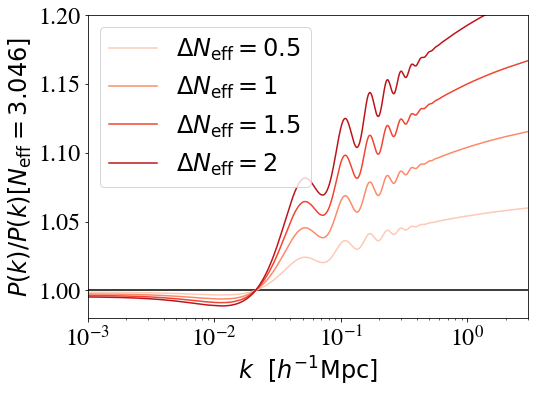

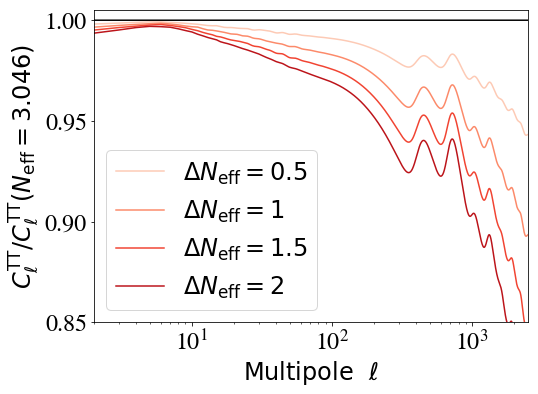

In [6]:
#############################################
#
# extract spectra and plot them
#
#############################################
kvec = np.logspace(-4,np.log10(3),1000) # array of kvec in h/Mpc
twopi = 2.*math.pi
#
# Create figures
#
fig_Pk, ax_Pk = plt.subplots()
fig_TT, ax_TT = plt.subplots()
#
# loop over varying parameter values
#
ll = {}
clM = {}
clTT = {}
pkM = {}
legarray = []

for i, N_ur in enumerate(var_array):
    #
    alpha = (1.+0.2271*N_ur)/(1.+0.2271*3.046)
    h = 0.67556*math.sqrt(alpha) # this is h
    #
    # deal with colors and legends
    #
    if i == 0:
        var_color = 'k'
        var_alpha = 1.
    else:
        var_color = plt.cm.Reds(0.8*i/(var_num-1))
    #
    # get Cls
    #
    clM[i] = M[i].lensed_cl(2500)
    ll[i] = clM[i]['ell'][2:]
    clTT[i] = clM[i]['tt'][2:]
    #
    # store P(k) for common k values
    #
    pkM[i] = []
    # The function .pk(k,z) wants k in 1/Mpc so we must convert kvec for each case with the right h 
    khvec = kvec*h # This is k in 1/Mpc
    for kh in khvec:
        pkM[i].append(M[i].pk(kh,0.)*h**3) 
    #    
    # plot P(k)
    #
    if i == 0:
        ax_Pk.semilogx(kvec,np.array(pkM[i])/np.array(pkM[0]),
                       color=var_color,#alpha=var_alpha,
                       linestyle='-')
    else:
        ax_Pk.semilogx(kvec,np.array(pkM[i])/np.array(pkM[0]),
                       color=var_color,#alpha=var_alpha,
                       linestyle='-',
                      label=r'$\Delta N_\mathrm{eff}=%g$'%(N_ur-3.046))
    #
    # plot C_l^TT
    #
    if i == 0:
        ax_TT.semilogx(ll[i],clTT[i]/clTT[0],
                       color=var_color,alpha=var_alpha,linestyle='-')
    else:    
        ax_TT.semilogx(ll[i],clTT[i]/clTT[0],
                       color=var_color,alpha=var_alpha,linestyle='-',
                      label=r'$\Delta N_\mathrm{eff}=%g$'%(N_ur-3.046))
#
# output of P(k) figure
#
ax_Pk.set_xlim([1.e-3,3.])
ax_Pk.set_ylim([0.98,1.20])
ax_Pk.set_xlabel(r'$k \,\,\,\, [h^{-1}\mathrm{Mpc}]$')
ax_Pk.set_ylabel(r'$P(k)/P(k)[N_\mathrm{eff}=3.046]$')
ax_Pk.legend(loc='upper left')
fig_Pk.tight_layout()
fig_Pk.savefig('ratio-%s-Pk.pdf' % var_figname)
#
# output of C_l^TT figure
#      
ax_TT.set_xlim([2,2500])
ax_TT.set_ylim([0.850,1.005])
ax_TT.set_xlabel(r'$\mathrm{Multipole} \,\,\,\,  \ell$')
ax_TT.set_ylabel(r'$C_\ell^\mathrm{TT}/C_\ell^\mathrm{TT}(N_\mathrm{eff}=3.046)$')
ax_TT.legend(loc='lower left')
fig_TT.tight_layout()
fig_TT.savefig('ratio-%s-cltt.pdf' % var_figname)
#
# output of C_l^EE figure
#    
#ax_EE.set_xlim([2,2500])
#ax_EE.set_xlabel(r'$\ell$')
#ax_EE.set_ylabel(r'$[\ell(\ell+1)/2\pi]  C_\ell^\mathrm{EE}$')
#ax_EE.legend(legarray,loc='lower right')
#fig_EE.tight_layout()
#fig_EE.savefig('spectra_%s_clee.pdf' % var_figname)
#
# output of C_l^pp figure
#   
#ax_PP.set_xlim([10,2500])
#ax_PP.set_xlabel(r'$\ell$')
#ax_PP.set_ylabel(r'$[\ell^2(\ell+1)^2/2\pi]  C_\ell^\mathrm{\phi \phi}$')
#ax_PP.legend(legarray)
#fig_PP.tight_layout()
#fig_PP.savefig('spectra_%s_clpp.pdf' % var_figname)